## Using SGD on MNIST

## Background

### ... about machine learning (a reminder from lesson 1)

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1. Ensembles of decision trees (i.e. Random Forests and Gradient Boosting Machines), mainly for structured data (such as you might find in a database table at most companies).  We looked at random forests in depth as we analyzed the Blue Book for Bulldozers dataset.

2. Multi-layered neural networks learnt with SGD (i.e. shallow and/or deep learning), mainly for unstructured data (such as audio, vision, and natural language)

In this lesson, we will start on the 2nd approach (a neural network with SGD) by analyzing the MNIST dataset.  You may be surprised to learn that **logistic regression is actually an example of a simple neural net**!

### About The Data

In this lesson, we will be working with MNIST, a classic data set of hand-written digits.  Solutions to this problem are used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

## Imports and data

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from mlutils.io import get_data
from mlutils.plot import plot_confusion_matrix, plot_keras_history
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [19]:
path = 'data/mnist/'

In [20]:
import os
os.makedirs(path, exist_ok=True)

In [21]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [22]:
get_data(URL+FILENAME, path+FILENAME)
((x_train, y_train), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [23]:
type(x_train), x_train.shape, type(y_train), y_train.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

### Normalize

Many machine learning algorithms behave better when the data is *normalized*, that is when the mean is 0 and the standard deviation is 1. We will subtract off the mean and standard deviation from our training set in order to normalize the data:

In [24]:
mean = x_train.mean()
std = x_train.std()

# normalize
x_train=(x_train-mean)/std

# x.mean should be close to 0 and std close to 1
mean, std, np.round(x_train.mean(),3), np.round(x_train.std(), 3)

(0.13044983, 0.3072898, -0.0, 1.0)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [25]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

### Look at the data

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [26]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [27]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

#### Plots 

In [28]:
x_valid.shape

(10000, 784)

In [29]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

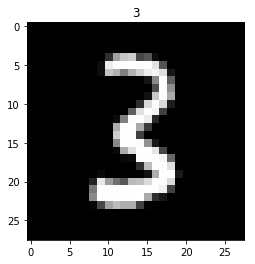

In [30]:
show(x_imgs[0], y_valid[0])

In [31]:
y_valid.shape

(10000,)

It's the digit 3!  And that's stored in the y value:

In [32]:
y_valid[0]

3

We can look at part of an image:

In [33]:
x_imgs[0,10:15,10:15]

array([[-0.42451727, -0.42451727, -0.42451727, -0.42451727,  0.17294396],
       [-0.42451727, -0.42451727, -0.42451727,  0.7831172 ,  2.4356694 ],
       [-0.42451727, -0.27197397,  1.2026112 ,  2.778892  ,  2.8043158 ],
       [-0.42451727,  1.7619367 ,  2.8043158 ,  2.8043158 ,  1.7365128 ],
       [-0.42451727,  2.2068546 ,  2.8043158 ,  2.8043158 ,  0.4017589 ]],
      dtype=float32)

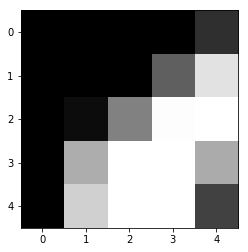

In [34]:
show(x_imgs[0,10:15,10:15])

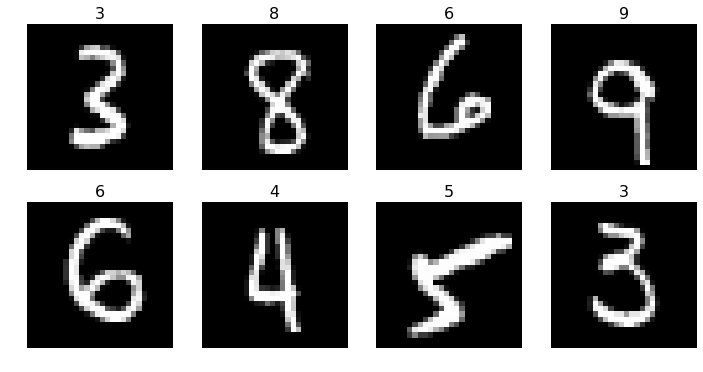

In [35]:
plots(x_imgs[:8], titles=y_valid[:8])

## Neural Networks

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

Using TensorFlow backend.


In [37]:
# create a subset to speed up training
subset = 10000
x_train = x_train[:subset]
y_train = y_train[:subset]

### Single layer network

In [38]:
# save original labels
y_train_original = y_train.copy()
y_valid_original = y_valid.copy()

# convert label to categorical
n_train = len(y_train)
y_all = np.concatenate((y_train, y_valid))

y_all = keras.utils.to_categorical(y_all)

y_train = y_all[:n_train]
y_valid = y_all[n_train:]

y_train.shape, y_valid.shape

((10000, 10), (10000, 10))

In [39]:
input_shape = (784,)
num_classes = 10

model = Sequential()
model.add(Dense(num_classes, activation='softmax', input_shape=input_shape))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Notice the number of trained parameters is equal to our input * num_nodes in the layer + num_nodes bias values

In this case 784 * 10 + 10 = 7850

In [41]:
h = model.fit(x_train,y_train, validation_data=(x_valid, y_valid))

Train on 10000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 4s 394us/step - loss: 0.6478 - acc: 0.8026 - val_loss: 0.3610 - val_acc: 0.8969


In [42]:
preds = model.predict(x_valid).argmax(1)

In [43]:
# this is our accuracy on validation data. Notice this trained in 1 second using the GPU
np.mean(preds == y_valid_original)

0.8969

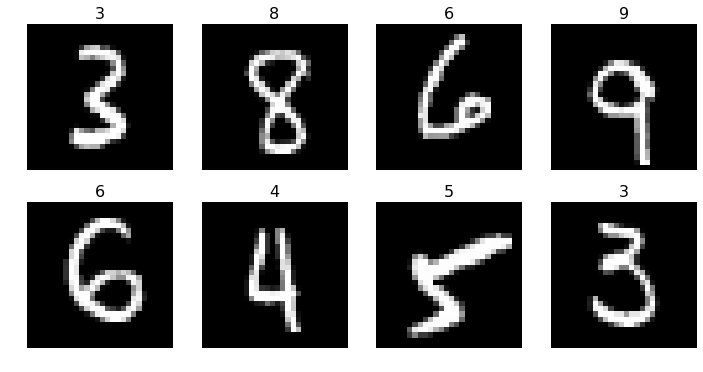

In [44]:
plots(x_imgs[:8], titles=preds[:8])

So we get a pretty high accuracy already, however if we increase the number of layers will be able to shape more complex rules and improve our accuracy.

For now, let's compare it with Scikit-learn's Logistic Regression, because it's basically the same thing as a 1-layer NN. Accuracy should be close, the big difference is the speed as keras will run on the GPU and Scikit-learn runs on CPU

## Using LogisticRegression

In [45]:
%%time
from sklearn.linear_model import LogisticRegression
m = LogisticRegression(max_iter=100).fit(x_train, y_train_original)

CPU times: user 39.2 s, sys: 6.82 ms, total: 39.2 s
Wall time: 39.2 s


In [46]:
# score model
preds = m.predict_proba(x_valid).argmax(1)
m.score(x_valid, y_valid_original)

0.8991

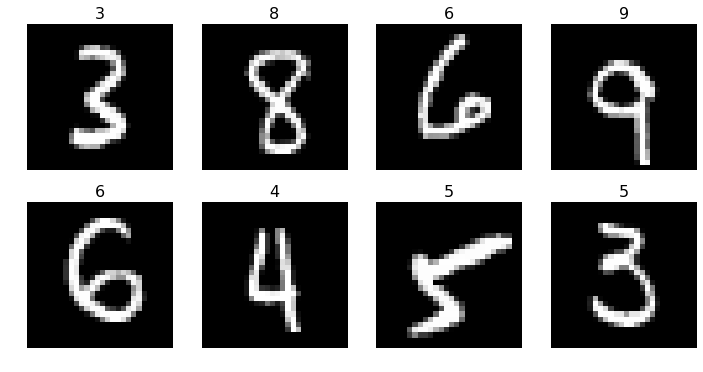

In [47]:
plots(x_imgs[:8], titles=preds[:8])

Notice accuracy is about the same but this took 40 seconds to train on CPU vs 1 second using Keras and the GPU

## Deep Neural Networks

In [48]:
input_shape = (784,)
num_classes = 10

model = Sequential()
model.add(Dense(100, activation='relu',input_shape=input_shape))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [50]:
# fit our model
h = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 1s 128us/step - loss: 0.8186 - acc: 0.7653 - val_loss: 0.3992 - val_acc: 0.8859
Epoch 2/20
10000/10000 [==============================] - 0s 46us/step - loss: 0.3488 - acc: 0.9006 - val_loss: 0.3239 - val_acc: 0.9040
Epoch 3/20
10000/10000 [==============================] - 0s 46us/step - loss: 0.2803 - acc: 0.9214 - val_loss: 0.2917 - val_acc: 0.9111
Epoch 4/20
10000/10000 [==============================] - 0s 46us/step - loss: 0.2411 - acc: 0.9323 - val_loss: 0.2658 - val_acc: 0.9191
Epoch 5/20
10000/10000 [==============================] - 1s 50us/step - loss: 0.2116 - acc: 0.9406 - val_loss: 0.2520 - val_acc: 0.9246
Epoch 6/20
10000/10000 [==============================] - 1s 51us/step - loss: 0.1890 - acc: 0.9476 - val_loss: 0.2341 - val_acc: 0.9309
Epoch 7/20
10000/10000 [==============================] - 1s 50us/step - loss: 0.1685 - acc: 0.9533 - val_loss: 0.2282 - val_ac

In [51]:
final_loss, final_acc = model.evaluate(x_valid, y_valid, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.183536, final accuracy: 0.948200


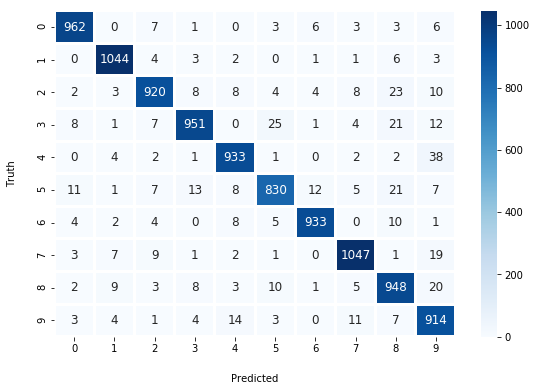

In [52]:
# Predict the values from the validation dataset
y_pred = model.predict(x_valid)

# Convert one hot vectors to prediction classes
y_pred_classes = np.argmax(y_pred, axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_valid_original, y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, range(10))

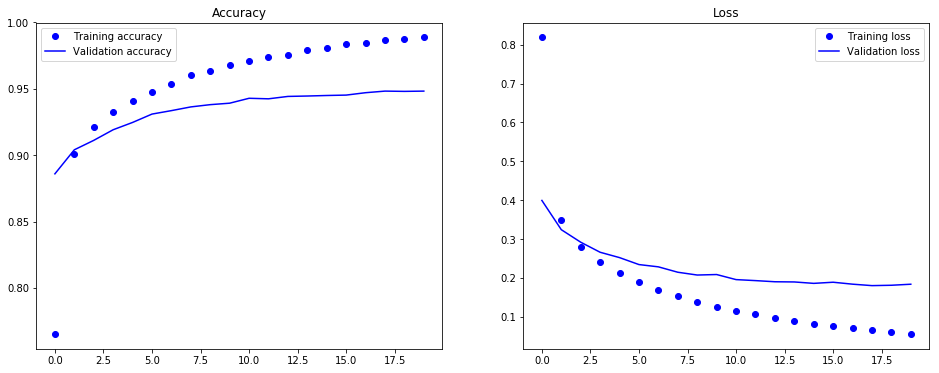

In [53]:
plot_keras_history(h)